# In this notebook we are plotting a test route, predicting counts of litter on it and calculating a relative error.

In [ ]:
# Install OSMNX only if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install osmnx
    !pip install matplotlib==3.1.1
    !pip install -U kaleido

In [ ]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1tfAjKLhhl3lteqf_EkFoyIPY2IdBJFVn'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("V2data_6mounts2022.csv.zip", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()
    !unzip V2data_6mounts2022.csv.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import sys
import pickle
import osmnx as ox
import networkx as nx
import urllib, json
import requests

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [4]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/data_processor.py')
    with open('data_processor.py', 'w') as f:
        f.write(r.text)
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/darkzone_creator.py')
    with open('darkzone_creator.py', 'w') as f:
        f.write(r.text)

import data_processor 
import darkzone_creator

## Dataset Import

In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: df_main_url = '/content/data.csv'
else: df_main_url = '../../../Information/output/datav2.csv'
df_main = pd.read_csv(df_main_url, dtype = {'place.id': object})
df_main.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
df_main = data_processor.clean_df(df_main)
df_main = data_processor.aggregate_df(df_main)
df_main['row_type'] = "ground truth"
df_main = data_processor.make_date_features(df_main)
df_main = data_processor.make_coordinates_features(df_main)
df_main = data_processor.make_edge_length_feature(df_main)
df_main = data_processor.make_weather_features(df_main)
df_main, osm_columns = data_processor.make_osm_features(df_main)
#df_main['date_utc'] = df_main['date_utc'].astype(str)

In [ ]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '190i18Wz2-HBXa82iajuNEPpCdFaOVL2r'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("darkzones_predicted.csv", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()


In [7]:
df_darkzones = pd.read_csv('/content/darkzones_predicted.csv')
df_darkzones.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
df_darkzones.drop('predicted_total', axis=1, inplace=True, errors='ignore')
df_darkzones.rename(columns = {'actual_total':'total_litter'}, inplace = True)

In [8]:
df = pd.concat([df_main, df_darkzones], ignore_index=True)

In [9]:
df.shape

(2381530, 78)

# Mapping

In [ ]:
def clean_coordinates(coordinates):
    new = []
    for pair in coordinates:
        new.append((pair[1], pair[0]))
    return new
with urllib.request.urlopen('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/data/edges.geojson') as url:
    data = json.loads(url.read().decode())
df_edges = pd.DataFrame(data['features'])  # <-- The only column needed
df_edges.rename(columns = {'id':'edge_id'}, inplace = True)
df_edges = pd.concat([df_edges.drop(['geometry'], axis=1), df_edges['geometry'].apply(pd.Series)], axis=1)  # <--Explode dictionary inside cells
df_edges = pd.concat([df_edges.drop(['properties'], axis=1), df_edges['properties'].apply(pd.Series)], axis=1)  # <--Explode dictionary inside cells
df_edges = df_edges[['edge_id', 'coordinates', 'name', 'highway']]
df_edges['coordinates'] = df_edges['coordinates'].apply(clean_coordinates)

In [11]:
df_edges['edge_id'].nunique()

15521

In [12]:
# north, south, west, east - latitude and longitude coordinates

route = []
for index, row in df_edges.iterrows():
    for pair in row['coordinates']:
        if (pair[0] < north) & (pair[0] > south) & (pair[1] > west) & (pair[1] < east):
            route.append(row['edge_id'])

route = list(set(route))
len(route)

125

In [13]:
import folium
df['date_utc'] = df['date_utc'].astype(str)
df_map = df[df['date_utc'] == '2022-10-20']

df_map_route = df_map[pd.DataFrame(df_map['edge_id'].tolist()).isin(route).any(1).values]

df_map_ground = df_map_route[(df_map_route['row_type'] == "ground truth")]
df_map_darkzone = df_map_route[(df_map_route['row_type'] == "darkzone")]


In [ ]:
all_litters_on_route_ground = dict.fromkeys(df_map_ground.columns[4:34])
all_litters_on_route_darkzone = dict.fromkeys(df_map_darkzone.columns[4:34])
for key in all_litters_on_route_ground.keys():
  all_litters_on_route_ground[key] = df_map_ground[key].sum()
  all_litters_on_route_darkzone[key] = df_map_darkzone[key].sum()
all_litters_on_route_ground, all_litters_on_route_darkzone

In [ ]:
lst_for_on_route = ['3', '4', '1', '21', '35', '33', '49', 'total_litter']
litters_on_route_ground = {}
litters_on_route_darkzone = {}
for lit in lst_for_on_route:
  litters_on_route_ground[lit] = all_litters_on_route_ground[lit]
  litters_on_route_darkzone[lit] = all_litters_on_route_darkzone[lit]
litters_on_route_ground, litters_on_route_darkzone

In [ ]:
route_map = folium.Map(location=[47.5596, 7.5886], zoom_start=14, prefer_canvas=True, tiles="cartodbpositron")

for index, row in df_map_ground.iterrows():
        loc = df_edges['coordinates'][df_edges['edge_id'] == row['edge_id']].tolist()
        loc = loc[0]
        folium.PolyLine(loc, color='seagreen',weight=3,opacity=1).add_to(route_map)
for index, row in df_map_darkzone.iterrows():
        loc = df_edges['coordinates'][df_edges['edge_id'] == row['edge_id']].tolist()
        loc = loc[0]
        folium.PolyLine(loc, color='indianred',weight=2,opacity=1).add_to(route_map)

route_map

In [ ]:
route_map.save('map2.html')

Here should be an image of the route on a map, however, for private purposes it has to be hidden.

# Relative error

In [22]:
import cloudpickle as cp
from urllib.request import urlopen 

In [23]:
if IN_COLAB:
    url = "https://github.com/dominik117/data-science-toolkit/blob/main/data/models_dictionary.pkl?raw=true"
    models = cp.load(urlopen(url)) 
else:
    with open('models_dictionary.pkl', 'rb') as f:
        models = pickle.load(f)


In [24]:
df_main_predicted = df_main.copy()
for key, model in models.items():
    predictions = model[0].predict(df_main_predicted)
    predictions = np.rint(predictions).astype(int)
    df_main_predicted[f"{key}_pred"] = predictions
columns_to_drop = ['Year', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 
        'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 
        'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']
columns_to_drop.extend(osm_columns)
df_main_predicted.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# Runtime ~2 minutes
# df_main = df_main_predicted.copy()

In [ ]:
relative_errors = {}
for lit, values in litters_on_route_ground.items():

  df_test = df_main_predicted[['date_utc', 'edge_id', lit, lit + '_pred']]
  df_test = df_test.groupby(['edge_id'], as_index=False).agg({lit:'sum', lit + '_pred':'sum'})
  df_test = df_test.sample(n=14000, random_state=1).copy().reset_index(drop=True)

  agg_n_edges = [len(route)]

  ticks = []
  relative_error = []
  for n_edges in agg_n_edges:
      df_loop = df_test.groupby(df_test.index // n_edges).agg({lit:'sum', lit + '_pred':'sum'})
      errors = []
      for row in df_loop.values:
          diff = abs(row[1] - row[0])
          error = round((diff*100)/row[0], 8)
          errors.append(error)
      errors = np.array(errors)
      relative_error.append([n_edges, round(np.mean(errors), 2)])
      relative_errors[lit] = relative_error[0][1]
      print(relative_error,lit, relative_errors[lit])
      ticks.append([n_edges, errors])

In [28]:
relative_errors

{'3': 2.57,
 '4': 1.61,
 '1': 1.71,
 '21': 11.6,
 '35': 9.34,
 '33': 20.67,
 '49': 40.83,
 'total_litter': 1.46}

In [29]:
litter_dict = {'1': 'Cigarette', '2': 'Leaf', '3': 'Leaves', '4': 'Paper/Carton', '5': 'CAN',
               '7': 'Glass bottle', '8': 'PET', '9': 'Carton drink', '10': 'FF Cup', '11': 'FF Foam Polystrene',
               '12': 'Other Foam Polystrene', '13': 'Food packaging', '14': 'Newspaper', '15': 'Small bag',
               '16': 'Glass Splinter', '17': 'Syringe', '18': 'Organic food littering', '19': 'Dog fouling',
               '21': 'Garbage bags', '22': 'Sand/Grit/Granulate', '23': 'Chewing- gum', '24': 'Vomit', '25': 'FF Cup',
               '26': 'FF Lid', '27': 'FF Straw', '28': 'FF Fries cartin', '29': 'Unclear bottles', 
               '30': 'FF Burger Box', '31': 'FF Paper', '32': 'FF Other Paper', '33': 'iQos', '34': 'Confettis (pile)',
               '35': 'Medium/big stain', '36': 'Transparent plastic', '37': 'Opaque plastic', '38': 'Fabric', 
               '39': 'Unrecognizable', '40': 'Capsule', '41': 'Carcass', '42': 'Furniture', '43': 'Tag',
               '44': 'Poster', '45': 'Waste bin stain', '46': 'Waste bin tag', '47': 'Waste bin sticker',
               '48': 'Waste bin Ouverture', '49': 'Waste bin', '50': 'Cigarette white', '51': 'Cigarette rolled',
               '52': 'Cigarette unknown', '53': 'Waste container too full', '54': 'Illegal advertising poster',
               '55': 'Illegal advertising poster (influenceable)', '56': 'Illegal litters', 
               '57': 'Spray painting, graffiti', '58': 'Spray painting, graffiti (influenceable)',
               '59': 'Feuille mouillée', '60': 'Poubelles remplies', '61': 'Robydog', '62': 'Wooden or plastic crate',
               '63': 'Mask', 'total_litter': 'Total litter'}

In [30]:
litters_on_route_df = pd.DataFrame(columns=['litter_type', 'value', 'relative_error'])
litters_on_route_df['litter_type'] = relative_errors.keys()
litters_on_route_df['value_ground'] = litters_on_route_df['litter_type'].apply(lambda x: litters_on_route_ground[x])
litters_on_route_df['value_darkzone'] = litters_on_route_df['litter_type'].apply(lambda x: litters_on_route_darkzone[x])
litters_on_route_df['value'] = litters_on_route_df['value_ground'] + litters_on_route_df['value_darkzone']
litters_on_route_df['relative_error'] = litters_on_route_df['litter_type'].apply(lambda x: relative_errors[x])
litters_on_route_df['relative_error'] = litters_on_route_df['relative_error']
litters_on_route_df['litter_type_name'] = litters_on_route_df['litter_type'].apply(lambda x: litter_dict[x])
litters_on_route_df.sort_values(by='value', ascending=False, inplace=True)                                      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

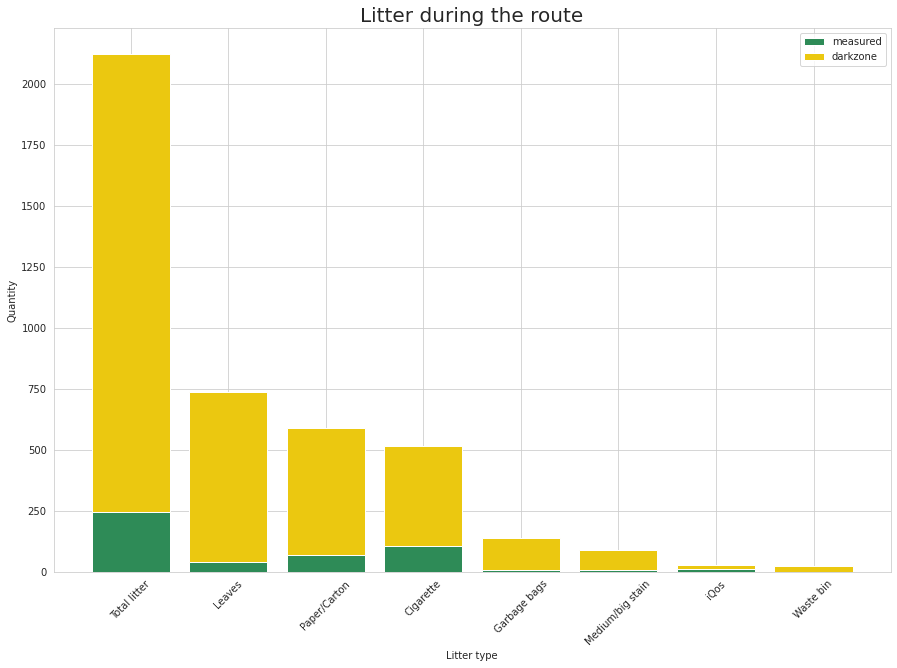

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(x=litters_on_route_df['litter_type_name'], height=litters_on_route_df['value_ground'], color='seagreen', label='measured')
plt.bar(x=litters_on_route_df['litter_type_name'], height=litters_on_route_df['value_darkzone'], color='#ebc810', bottom = litters_on_route_df['value_ground'], label='darkzone')
ax.set_title('Litter during the route', size=20)
ax.set_xlabel("Litter type")
plt.xticks(rotation=45)
plt.legend()
plt.rcParams.update({'font.size': 14})
ax.set_ylabel("Quantity");
fig.show()
fig.savefig('Litter_during_the_route.pdf');
files.download('Litter_during_the_route.pdf')

In [32]:
from plotly.offline import iplot
import plotly.graph_objects as go

# chart 1
chart1 = go.Bar(x=litters_on_route_df['litter_type_name'], y=litters_on_route_df['value_ground'], name='From Measured', marker_color='seagreen') #change the name to your liking and color
# chart 2
chart2 = go.Bar(x=litters_on_route_df['litter_type_name'], y=litters_on_route_df['value_darkzone'], name='From Darkzone', marker_color='#ebc810')
# chart 3
chart3 = go.Scatter(
    x=litters_on_route_df['litter_type_name'],
    y=litters_on_route_df['relative_error'],
    mode='lines+markers',
    line=dict(color='rgb(204, 0, 0)'),
    name='Relative error %',
    xaxis='x2',
    yaxis='y2',
)
 
data = [chart1, chart2, chart3]
 
# setting layout
layout = go.Layout(
 
    # setting y-axis position for chart 2
    xaxis2=dict(
        domain=[0.65, 0.95],
        anchor='y2'
    ),
 
    # setting y-axis position for chart 2
    yaxis2=dict(
        domain=[0.6, 0.95],
        anchor='x2'
    )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(barmode = 'stack', 
                  title = 'Litter during the route', 
                  yaxis_title = 'Litter quantity',
                  xaxis_title = 'Litter type',
                  template = 'plotly_white')
iplot(fig)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

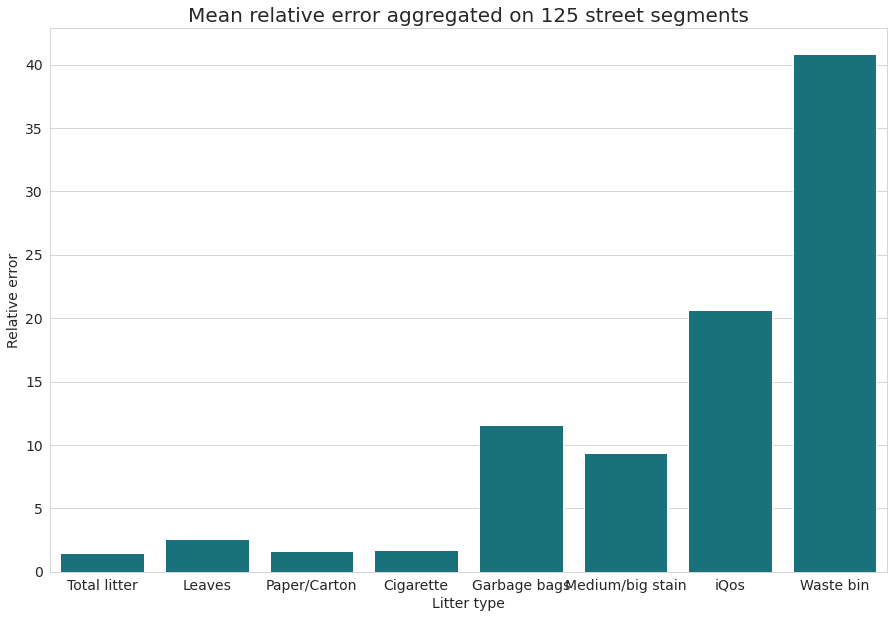

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=litters_on_route_df, x = 'litter_type_name', y='relative_error', color='#087E8B', ax=ax)
ax.set_title('Mean relative error aggregated on 125 street segments', size=20)
ax.set_xlabel("Litter type")
plt.xticks(rotation='horizontal')
ax.set_ylabel("Relative error");
fig.show()
fig.savefig('relative_errror_125_edges.pdf');
files.download('relative_errror_125_edges.pdf')

In [34]:
df_main_predicted_route = pd.DataFrame(columns = df_main_predicted.columns)
for i in route:
  df_main_predicted_route = df_main_predicted_route.append(df_main_predicted[df_main_predicted['edge_id']  == i])
df_main_predicted_route['edge_id'].nunique()

125

In [35]:
df_main_predicted_route = df_main_predicted_route.groupby('edge_id').agg({
    'total_litter' : 'sum', 'total_litter_pred':'sum', '3' : 'sum', '3_pred' : 'sum',
     '4' : 'sum', '4_pred' : 'sum', '1' : 'sum', '1_pred' : 'sum', '21' : 'sum', 
     '21_pred' : 'sum', '35' : 'sum', '35_pred' : 'sum',  '33' : 'sum', '33_pred' : 'sum',
     '49' : 'sum', '49_pred' : 'sum'
})

In [36]:
df_main_predicted_route.shape

(125, 16)